In [23]:
import os
import sys 
import torch
from collections import Counter
import json
import random
import matplotlib.pyplot as plt
import numpy as np

In [24]:
sys.path.append("../utils/")
from plot_utils import EmbeddingPlotter

# Load embeddings and embedding to image mapping

In [25]:
# Read embeddings. Change filepaths as needed to visualize your embeddings
embeddings_fp = "../data/embeddings"
embeddings_path = embeddings_fp + "/mini-resnet18_embeddings.pt"
mapping_path = embeddings_fp + "/mini-resnet18_embeddings-v2.json"
embeddings = torch.load(embeddings_path,map_location=torch.device('cpu'))

with open(mapping_path, 'r') as fp:
    idx2Img = json.load(fp)
    
idx2Img = dict(zip(list(map(int, idx2Img.keys())), list(idx2Img.values())))

In [26]:
# Update based on the location in your system
annot_file = "../../../coco/annotations/instances_val2014.json"

# Query images and their position in embedding space

In [27]:
query_images = [100582, 38210, 495291]
query_idxs = [key for key, value in idx2Img.items() if value in query_images]
print("query image ids: ", query_images)
print("query image idxs: ", query_idxs)

query image ids:  [100582, 38210, 495291]
query image idxs:  [1059, 6716, 18611]


# Initialize plotting utility

In [28]:
plotter = EmbeddingPlotter(annot_file = annot_file, embeddings=embeddings, idx2Img=idx2Img)

loading annotations into memory...
Done (t=5.75s)
creating index...
index created!


# Plot query images

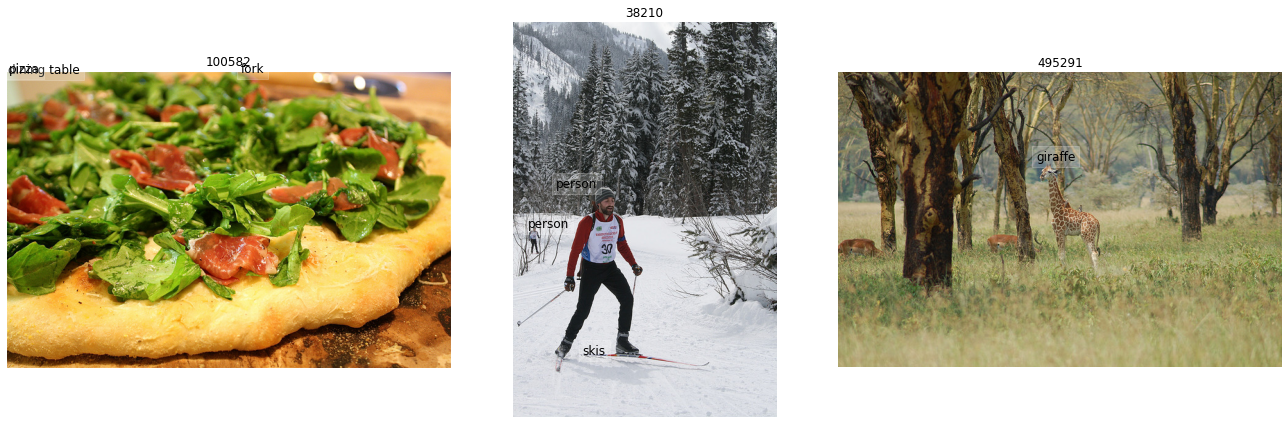

In [29]:
plotter.plot_coco_images([query_images])

# Use K-Neighbors to find similar images across embedded space

In [30]:
from sklearn.neighbors import NearestNeighbors

nbrs = NearestNeighbors(n_neighbors=11, algorithm='auto', metric='cosine').fit(embeddings)

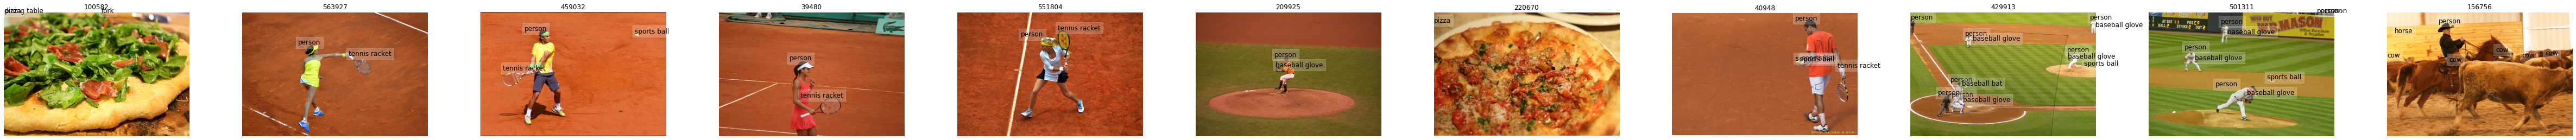

In [31]:
# Recall that plot_neighbors takes index position of embeddings as input
plotter.plot_neighbors(1059, k=nbrs.n_neighbors, nbrs=nbrs)

# PCA on Embeddings

In [ ]:
embeddings.size()

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2000)
X_pca = pca.fit_transform(embeddings)
plt.plot(range(X_pca.shape[1]), np.cumsum(pca.explained_variance_ratio_))
plt.title('Cumulative sum of explained variance by each component')
plt.show()

In [ ]:
plotter.plot_3d(X=X_pca[:, :3], title='PCA grouping by COCO categories', columns=['PCA_1', 'PCA_2', 'PCA_3'], alpha=0.2)

# Search Precision

In [32]:
def recall(plotter, idx, nbrs, k=5, category=True, reduced_space=None):
    
    # If/else block to override embeddings stored in plotter to use a reduced (e.g. PCA) space
    if reduced_space is None:
        embeddings = plotter.embeddings
        m, n = embeddings.size()
    else:
        embeddings = reduced_space
        m, n = np.shape(embeddings)
        
    # run KNN on image at index location idx
    distances, indices = nbrs.kneighbors(embeddings[idx, :].reshape(1, n), nbrs.n_neighbors)
    
    # Slice results from KNN to only have k returned images
    retrieved_distances = distances[0][1:k+1] # top 4 images
    retrieved_indices = indices[0][1:k+1] # top 4 image locations
    
    # For category and supercategory metrics, get the labels retrieved from the KNN search in its entirety, as well as the top 4
    if category == True:
        ground_truth = plotter.category_labels[idx]
        total_retrieved_labels = itemgetter(*indices[0][1:])(plotter.category_labels) # labels from all 10 KNN results
        retrieved_labels = itemgetter(*retrieved_indices)(plotter.category_labels) # labels from top 4 images
    else:
        ground_truth = plotter.supercategory_labels[idx]
        total_retrieved_labels = itemgetter(*indices[0][1:])(plotter.supercategory_labels)
        retrieved_labels = itemgetter(*retrieved_indices)(plotter.supercategory_labels)
    
    # get list of relevant labels from the search
    relevant_labels = [i for i in total_retrieved_labels if i == ground_truth]
    
    # recall = (relevant labels in top 4) / (relevant labels in search)
    recall = np.array([1 if i == ground_truth else 0 for i in retrieved_labels]).sum() / len(relevant_labels)
    if len(relevant_labels) == 0:
        return 0
    else:
        return recall
    
    

In [33]:
def avg_recall(plotter, nbrs, query_idxs, k=5, category=True, reduced_space=None):
    avg_recall = 0
    for idx in query_idxs:
        avg_recall += recall(plotter, idx, nbrs, k, category, reduced_space)
    avg_recall = avg_recall / len(query_idxs)
    return avg_recall

In [34]:
from operator import itemgetter

def precision(plotter, idx, nbrs, k=4, category=True, reduced_space=None):
    # If/else block to override embeddings stored in plotter to use a reduced (e.g. PCA) space
    if reduced_space is None:
        embeddings = plotter.embeddings
        m, n = embeddings.size()
    else:
        embeddings = reduced_space
        m, n = np.shape(embeddings)
        
    # run KNN on image at index location idx   
    distances, indices = nbrs.kneighbors(embeddings[idx, :].reshape(1, n), nbrs.n_neighbors)
    
    # Slice results from KNN to only have k returned images
    retrieved_distances = distances[0][1:k+1] # top 4 distances
    retrieved_indices = indices[0][1:k+1] # top 4 image locations
    
    # For category and supercategory metrics, get the labels retrieved from the KNN search in its entirety, as well as the top 4
    if category == True:
        ground_truth = plotter.category_labels[idx]
        retrieved_labels = itemgetter(*retrieved_indices)(plotter.category_labels)
    else:
        ground_truth = plotter.supercategory_labels[idx]
        retrieved_labels = itemgetter(*retrieved_indices)(plotter.supercategory_labels)
     
    # precision = (number of relevant images in top k) / (number of images retrieved in knn)
    precision = np.array([1 if i == ground_truth else 0 for i in retrieved_labels]).sum() / (nbrs.n_neighbors-1)
    return precision

In [35]:
def avg_precision(plotter, nbrs, query_idxs, k=5, category=True, reduced_space=None):
    avg_precision = 0
    for idx in query_idxs:
        avg_precision += precision(plotter, idx, nbrs, k, category, reduced_space)
    avg_precision = avg_precision / len(query_idxs)
    return avg_precision

In [36]:
category_precision = avg_precision(plotter, nbrs, query_idxs, k=4, category=False)
supercategory_precision = avg_precision(plotter, nbrs, query_idxs, k=4, category=True)
print("Category-level precision: {}%".format(round(category_precision*100, 2)))
print("Supercategory-level precision: {}%".format(round(supercategory_precision*100, 2)))

Category-level precision: 20.0%
Supercategory-level precision: 10.0%


# Search Precision by K-Neighbors Distance Metric

In [37]:
# Cosine Distance
nbrs = NearestNeighbors(n_neighbors=11, algorithm='auto', metric='cosine').fit(embeddings)
category_precision = avg_precision(plotter, nbrs, query_idxs, k=4, category=False)
supercategory_precision = avg_precision(plotter, nbrs, query_idxs, k=4, category=True)
print("Category-level precision: {}%".format(round(category_precision*100, 2)))
print("Supercategory-level precision: {}%".format(round(supercategory_precision*100, 2)))

Category-level precision: 20.0%
Supercategory-level precision: 10.0%


In [38]:
# Minkowski Distance
#nbrs = NearestNeighbors(n_neighbors=11, algorithm='auto', metric='minkowski').fit(embeddings)
category_precision = avg_precision(plotter, nbrs, query_idxs, category=False)
supercategory_precision = avg_precision(plotter, nbrs, query_idxs, category=True)
print("Category-level precision: {}%".format(round(category_precision*100, 2)))
print("Supercategory-level precision: {}%".format(round(supercategory_precision*100, 2)))

Category-level precision: 23.33%
Supercategory-level precision: 10.0%


In [39]:
# Euclidean Distance
#nbrs = NearestNeighbors(n_neighbors=11, algorithm='auto', metric='euclidean').fit(embeddings)
category_precision = avg_precision(plotter, nbrs, query_idxs, category=False)
supercategory_precision = avg_precision(plotter, nbrs, query_idxs, category=True)
print("Category-level precision: {}%".format(round(category_precision*100, 2)))
print("Supercategory-level precision: {}%".format(round(supercategory_precision*100, 2)))

Category-level precision: 23.33%
Supercategory-level precision: 10.0%


In [40]:
# Manhattan Distance
#nbrs = NearestNeighbors(n_neighbors=11, algorithm='auto', metric='manhattan').fit(embeddings)
category_precision = avg_precision(plotter, nbrs, query_idxs, category=False)
supercategory_precision = avg_precision(plotter, nbrs, query_idxs, category=True)
print("Category-level precision: {}%".format(round(category_precision*100, 2)))
print("Supercategory-level precision: {}%".format(round(supercategory_precision*100, 2)))

Category-level precision: 23.33%
Supercategory-level precision: 10.0%


# Search Precision in Reduced Space

In [ ]:
# Cosine Distance
nbrs = NearestNeighbors(n_neighbors=16, algorithm='auto', metric='cosine').fit(X_pca[:, :30])
category_precision = avg_precision(plotter, nbrs, query_idxs, category=False, reduced_space=X_pca[:, :30])
supercategory_precision = avg_precision(plotter, nbrs, query_idxs, category=True, reduced_space=X_pca[:, :30])
print("Category-level precision: {}%".format(round(category_precision*100, 2)))
print("Supercategory-level precision: {}%".format(round(supercategory_precision*100, 2)))

In [ ]:
# Minkowski Distance
nbrs = NearestNeighbors(n_neighbors=16, algorithm='auto', metric='minkowski').fit(X_pca[:, :30])
category_precision = avg_precision(plotter, nbrs, query_idxs, category=False, reduced_space=X_pca[:, :30])
supercategory_precision = avg_precision(plotter, nbrs, query_idxs, category=True, reduced_space=X_pca[:, :30])
print("Category-level precision: {}%".format(round(category_precision*100, 2)))
print("Supercategory-level precision: {}%".format(round(supercategory_precision*100, 2)))

In [ ]:
# Euclidean Distance
nbrs = NearestNeighbors(n_neighbors=16, algorithm='auto', metric='euclidean').fit(X_pca[:, :30])
category_precision = avg_precision(plotter, nbrs, query_idxs, category=False, reduced_space=X_pca[:, :30])
supercategory_precision = avg_precision(plotter, nbrs, query_idxs, category=True, reduced_space=X_pca[:, :30])
print("Category-level precision: {}%".format(round(category_precision*100, 2)))
print("Supercategory-level precision: {}%".format(round(supercategory_precision*100, 2)))

In [ ]:
# Manhattan Distance
nbrs = NearestNeighbors(n_neighbors=16, algorithm='auto', metric='manhattan').fit(X_pca[:, :30])
category_precision = avg_precision(plotter, nbrs, query_idxs, category=False, reduced_space=X_pca[:, :30])
supercategory_precision = avg_precision(plotter, nbrs, query_idxs, category=True, reduced_space=X_pca[:, :30])
print("Category-level precision: {}%".format(round(category_precision*100, 2)))
print("Supercategory-level precision: {}%".format(round(supercategory_precision*100, 2)))

# Search Recall using KNN K=4

In [41]:
# Cosine Distance
#nbrs = NearestNeighbors(n_neighbors=11, algorithm='auto', metric='cosine').fit(embeddings)
category_recall = avg_recall(plotter, nbrs, query_idxs, k=4, category=False)
supercategory_recall = avg_recall(plotter, nbrs, query_idxs, k=4, category=True)
print("Category-level recall: {}%".format(round(category_recall*100, 2)))
print("Supercategory-level recall: {}%".format(round(supercategory_recall*100, 2)))

<ipython-input-32-51a9c867554d>:20: RuntimeWarning: invalid value encountered in long_scalars
  recall = np.array([1 if i == ground_truth else 0 for i in retrieved_labels]).sum() / len(relevant_labels)
<ipython-input-32-51a9c867554d>:20: RuntimeWarning: invalid value encountered in long_scalars
  recall = np.array([1 if i == ground_truth else 0 for i in retrieved_labels]).sum() / len(relevant_labels)


Category-level recall: 30.95%
Supercategory-level recall: 14.29%


<ipython-input-32-51a9c867554d>:20: RuntimeWarning: invalid value encountered in long_scalars
  recall = np.array([1 if i == ground_truth else 0 for i in retrieved_labels]).sum() / len(relevant_labels)


In [42]:
# Minkowski Distance
#nbrs = NearestNeighbors(n_neighbors=11, algorithm='auto', metric='minkowski').fit(embeddings)
category_recall = avg_recall(plotter, nbrs, query_idxs, k=4, category=False)
supercategory_recall = avg_recall(plotter, nbrs, query_idxs, k=4, category=True)
print("Category-level recall: {}%".format(round(category_recall*100, 2)))
print("Supercategory-level recall: {}%".format(round(supercategory_recall*100, 2)))

<ipython-input-32-51a9c867554d>:20: RuntimeWarning: invalid value encountered in long_scalars
  recall = np.array([1 if i == ground_truth else 0 for i in retrieved_labels]).sum() / len(relevant_labels)
<ipython-input-32-51a9c867554d>:20: RuntimeWarning: invalid value encountered in long_scalars
  recall = np.array([1 if i == ground_truth else 0 for i in retrieved_labels]).sum() / len(relevant_labels)


Category-level recall: 30.95%
Supercategory-level recall: 14.29%


<ipython-input-32-51a9c867554d>:20: RuntimeWarning: invalid value encountered in long_scalars
  recall = np.array([1 if i == ground_truth else 0 for i in retrieved_labels]).sum() / len(relevant_labels)


In [43]:
# Euclidean Distance
#nbrs = NearestNeighbors(n_neighbors=11, algorithm='auto', metric='euclidean').fit(embeddings)
category_recall = avg_recall(plotter, nbrs, query_idxs, k=4, category=False)
supercategory_recall = avg_recall(plotter, nbrs, query_idxs, k=4, category=True)
print("Category-level recall: {}%".format(round(category_recall*100, 2)))
print("Supercategory-level recall: {}%".format(round(supercategory_recall*100, 2)))

<ipython-input-32-51a9c867554d>:20: RuntimeWarning: invalid value encountered in long_scalars
  recall = np.array([1 if i == ground_truth else 0 for i in retrieved_labels]).sum() / len(relevant_labels)
<ipython-input-32-51a9c867554d>:20: RuntimeWarning: invalid value encountered in long_scalars
  recall = np.array([1 if i == ground_truth else 0 for i in retrieved_labels]).sum() / len(relevant_labels)


Category-level recall: 30.95%
Supercategory-level recall: 14.29%


<ipython-input-32-51a9c867554d>:20: RuntimeWarning: invalid value encountered in long_scalars
  recall = np.array([1 if i == ground_truth else 0 for i in retrieved_labels]).sum() / len(relevant_labels)


In [44]:
# Manhattan Distance
#nbrs = NearestNeighbors(n_neighbors=11, algorithm='auto', metric='manhattan').fit(embeddings)
category_recall = avg_recall(plotter, nbrs, query_idxs, k=4, category=False)
supercategory_recall = avg_recall(plotter, nbrs, query_idxs, k=4, category=True)
print("Category-level recall: {}%".format(round(category_recall*100, 2)))
print("Supercategory-level recall: {}%".format(round(supercategory_recall*100, 2)))

<ipython-input-32-51a9c867554d>:20: RuntimeWarning: invalid value encountered in long_scalars
  recall = np.array([1 if i == ground_truth else 0 for i in retrieved_labels]).sum() / len(relevant_labels)
<ipython-input-32-51a9c867554d>:20: RuntimeWarning: invalid value encountered in long_scalars
  recall = np.array([1 if i == ground_truth else 0 for i in retrieved_labels]).sum() / len(relevant_labels)


Category-level recall: 30.95%
Supercategory-level recall: 14.29%


<ipython-input-32-51a9c867554d>:20: RuntimeWarning: invalid value encountered in long_scalars
  recall = np.array([1 if i == ground_truth else 0 for i in retrieved_labels]).sum() / len(relevant_labels)
